<a href="https://colab.research.google.com/github/gwal0/TEST/blob/main/_1_0910_Pred_all_CT_1(Archive).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 푸리에 급수로 만든 이론적 압밀곡선을 input 데이터로 활용

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Sep 13 05:47:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
### Cell-01 // Setting PINN Environment
import os
os.environ["DDE_BACKEND"] = "tensorflow"

!pip install deepxde tensorflow matplotlib --quiet  # deepxde : PINN Framework

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import deepxde as dde
import tensorflow as tf

# Random Seed
USE_SEED = True
SEED_VALUE = 42

if USE_SEED:
    print(f"Random seed set to {SEED_VALUE}")
    os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
else:
    print("Random seed is not fixed (fully stochastic run)")

# Mount Data
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 10.9 MB/s eta 0:00:00


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



Random seed set to 42
Mounted at /content/drive


In [ ]:
### Cell-02 // Data Import and Test Value Setting
current_stage = "CT-1"       # ◀ Consolidation Test Load Stage

# Test Values of Load Stage
vals_file_path = '/content/drive/MyDrive/Colab Notebooks/INPUT/Test_values.xlsx'
df_vals = pd.read_excel(vals_file_path, engine='openpyxl')
print("[Test Values]")
print(df_vals)
row = df_vals.loc[df_vals["Stage"] == current_stage].iloc[0]
c_v_val = row["c_v[cm2/sec]"]
u_0_val = row["u_0"]
c_vi = tf.constant(c_v_val, dtype=tf.float32)
u_0i = tf.constant(u_0_val, dtype=tf.float32)
print()

# U_bar of Current Load Stage
print(f"[Current Stage]: {current_stage}")
exp_file_path = f'/content/drive/MyDrive/Colab Notebooks/INPUT/{current_stage}.xlsx'
df_exp = pd.read_excel(exp_file_path, engine='openpyxl')
t_exp = df_exp["time [min]"].values.reshape(-1, 1)
U_exp = df_exp["u_bar"].values.reshape(-1, 1)
print(df_exp.head())
print(f"□ c_v = {c_vi.numpy():.3E} cm²/sec ({c_vi.numpy():.6f})")
print(f"□ c_v = {c_vi.numpy()*60:.3E} cm²/min ({c_vi.numpy()*60:.6f})")
print(f"□ c_v = u_0 = {u_0i.numpy()} kPa")
print()

# Use test value
use_test_value_c_v = False       # ◀ If true → use test value, if else → use 0.01 [cm²/sec]
use_test_value_u_0 = False       # ◀ If true → use test value, if else → use 1 [kPa]

if use_test_value_c_v:
  c_v = tf.Variable(c_v_val*60, trainable=True, dtype=tf.float32, name="c_v") # [cm²/min]
else:
  c_v = tf.Variable(0.01, trainable=True, dtype=tf.float32, name="c_v") # [cm²/min]
if use_test_value_u_0:
  u_0 = tf.constant(u_0_val, dtype=tf.float32)
else:
  u_0 = tf.constant(1, dtype=tf.float32)

### Cell-03 // Setting Trainable Variable and Defining PDE
# 1D Consolidation PDE
def pde(x, u):
    du_t = dde.grad.jacobian(u, x, i=0, j=1)      # ∂u/∂t  (time derivative)
    du_zz = dde.grad.hessian(u, x, i=0, j=0)      # ∂²u/∂z² (second spatial derivative)
    return du_t - c_v * du_zz                     # (L_PDE) Eq. ∂u/∂t - ∂²u/∂z²= 0

### Cell-04 // Paramters Setting
# Domain
H = 2.0                                           # ◀ Thickness of Specimen [cm]
d = H/2                                           # ◀ Drainage Length (Double Drainage) [cm]
geom = dde.geometry.Interval(0, H)                # ◀ Spatial Domain [cm]
timedomain = dde.geometry.TimeDomain(0, 1440.0)   # ◀ Time Domain [min]
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define Initial Condition Function (AutoGraph OFF)
@tf.autograph.experimental.do_not_convert
def initial_func(x):
    return u_0 * tf.sin(np.pi * x[:, 0:1] / H)    # (L_IC) Eq. u(z, 0) = u_0 sin(pi z / H)
@tf.autograph.experimental.do_not_convert
def on_initial(x, on):
    return on

# Define Boundary Condition Function (AutoGraph OFF)
@tf.autograph.experimental.do_not_convert
def bc_func(x):
    return 0.0                                    # (L_BC) Eq. u(0,t) = u(H,t) = 0
@tf.autograph.experimental.do_not_convert
def on_boundary_func(x, on):
    return on

# Enforce Initial and Boundary Conditions
ic = dde.icbc.IC(geomtime, initial_func, on_initial)
bc = dde.icbc.DirichletBC(geomtime, bc_func, on_boundary_func)

### Cell-05 // PINN Pred.u(z,t) → Pred.U_bar
def compute_U_bar_PINN(model, t_tensor, H, num_points=100):
    # Uniformly sample along the z-axis (generate spatial grid in the z-direction)
    z = tf.linspace(0.0, H, num_points)          # [0,H]
    dz = H / (num_points - 1)                    # Spatial interval for integration

    # Create z-t meshgrid
    t = tf.reshape(t_tensor, [-1, 1])
    z_grid = tf.reshape(z, [1, -1])
    z_grid = tf.tile(z_grid, [tf.shape(t)[0], 1])
    t_grid = tf.tile(t, [1, num_points])

    # Construct input tensor
    input_tensor = tf.stack([tf.reshape(z_grid, [-1]),
                             tf.reshape(t_grid, [-1])], axis=1)

    # Perform PINN model prediction and Reshape
    u_pred = model.net(input_tensor, training=True)
    u_pred = tf.reshape(u_pred, [-1, num_points])

    # Define u₀(z) profile based on absolute values
    u0_profile = u_0 * tf.sin(np.pi * z / H)
    integral0 = tf.reduce_sum(u0_profile) * dz

    # Intergrate predicted values along z
    integral = tf.reduce_sum(u_pred, axis=1, keepdims=True) * dz

    # Compute average degree of consolidation
    U_bar = 1.0 - (integral / integral0)
    return U_bar

### Cell-06 // Define and Extend the Loss Function
# Define custom data loss
def custom_data_loss(model, t_exp, U_exp, H):
    t_tensor = tf.convert_to_tensor(t_exp, dtype=tf.float32)
    U_tensor = tf.convert_to_tensor(U_exp, dtype=tf.float32)
    U_pred = compute_U_bar_PINN(model, t_tensor, H)
    return tf.reduce_mean(tf.square(U_pred - U_tensor))  # → (L_data) Eq. Pred.U_bar-True.U_bar

# Define Loss Weight
λ_pde = tf.constant(1.0, dtype=tf.float32)       # ◀ Weight of L_PDE
λ_bc  = tf.constant(1.0, dtype=tf.float32)       # ◀ Weight of L_BC
λ_ic  = tf.constant(1.0, dtype=tf.float32)       # ◀ Weight of L_IC
λ_data= tf.constant(1.0, dtype=tf.float32)       # ◀ Weight of L_Data

# Extend the user-defined TimePDE class (add L_data to the loss list)
class CustomTimePDE(dde.data.TimePDE):
    def losses(self, targets, outputs, loss_fn, inputs, model, aux=None):
        # Base physics losses (PDE, BC, IC)
        physics_losses = super().losses(targets, outputs, loss_fn, inputs, model, aux)

        # Separate individual loss terms
        L_pde = physics_losses[0]
        L_bc = physics_losses[1]
        L_ic = physics_losses[2]

        # Custom data loss (compare average degree of consolidation)
        L_data = custom_data_loss(model, t_exp, U_exp, H)

        # Apply weights and return the loss list
        return [
            λ_pde * L_pde,
            λ_bc * L_bc,
            λ_ic * L_ic,
            λ_data * L_data]

print(f"[Test Values used for Training]")
print(f"□ c_v_val = {c_v.numpy()/60:.3E} cm²/sec ({c_v.numpy()/60:.6f})")
print(f"□ c_v_val = {c_v.numpy():.3E} cm²/min ({c_v.numpy():.6f}) ◀ For Training")
print(f"□ u_0 = {u_0.numpy()} kPa")
print(f"□ Loss Weights: λ_pde = {λ_pde.numpy()}, λ_bc = {λ_bc.numpy()}, λ_ic = {λ_ic.numpy()}, λ_data = {λ_data.numpy()}")

[Test Values]
  Stage  Load [kPa]  c_v[cm2/sec]  u_0
0  CT-1          10      0.000305   10
1  CT-2          20      0.000286   10
2  CT-3          40      0.000258   20
3  CT-4          80      0.000209   40
4  CT-5         160      0.000180   80
5  CT-6         320      0.000134  160
6  CT-7         640      0.000109  320
7  CT-8        1280      0.000096  640

[Current Stage]: CT-1
   time [min]     u_bar
0        0.00  0.000020
1        0.25  0.076297
2        0.50  0.107900
3        1.00  0.152594
4        2.00  0.215801
□ c_v = 3.048E-04 cm²/sec (0.000305)
□ c_v = 1.829E-02 cm²/min (0.018288)
□ c_v = u_0 = 10.0 kPa

[Test Values used for Training]
□ c_v_val = 1.667E-04 cm²/sec (0.000167)
□ c_v_val = 1.000E-02 cm²/min (0.010000) ◀ For Training
□ u_0 = 1.0 kPa
□ Loss Weights: λ_pde = 1.0, λ_bc = 1.0, λ_ic = 1.0, λ_data = 1.0


Compiling model...
'compile' took 0.020203 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.40e-03, 1.51e-02, 1.74e+00, 8.62e-01]    [1.40e-03, 1.51e-02, 1.74e+00, 8.62e-01]    []  
1000      [1.93e-04, 3.04e-04, 7.41e-04, 1.17e-04]    [1.93e-04, 3.04e-04, 7.41e-04, 1.17e-04]    []  
2000      [1.26e-04, 2.38e-04, 3.75e-04, 1.03e-04]    [1.26e-04, 2.38e-04, 3.75e-04, 1.03e-04]    []  
3000      [7.06e-05, 1.97e-04, 1.70e-04, 7.95e-05]    [7.06e-05, 1.97e-04, 1.70e-04, 7.95e-05]    []  
4000      [3.10e-05, 1.56e-04, 5.12e-05, 5.69e-05]    [3.10e-05, 1.56e-04, 5.12e-05, 5.69e-05]    []  
5000      [2.71e-05, 8.64e-05, 1.35e-05, 3.58e-05]    [2.71e-05, 8.64e-05, 1.35e-05, 3.58e-05]    []  
6000      [3.69e-05, 3.36e-05, 5.90e-06, 2.24e-05]    [3.69e-05, 3.36e-05, 5.90e-06, 2.24e-05]    []  
7000      [4.08e-05, 1.68e-05, 3.56e-06, 1.77e-05]    [4.08e-05, 1.68e-05, 3.56e-06, 1.77e-05]    []  
8

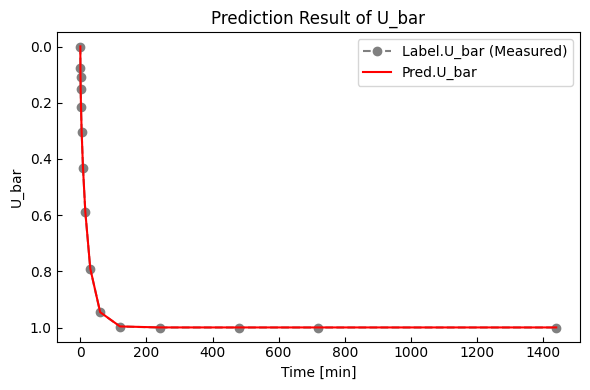

    Time [min]  Label.U_bar  Pred.U_bar
0         0.00   2.0262e-05     -0.0008
1         0.25   7.6297e-02      0.0759
2         0.50   1.0790e-01      0.1076
3         1.00   1.5259e-01      0.1525
4         2.00   2.1580e-01      0.2158
5         4.00   3.0519e-01      0.3052
6         8.00   4.3154e-01      0.4315
7        15.00   5.8786e-01      0.5875
8        30.00   7.9065e-01      0.7900
9        60.00   9.4593e-01      0.9455
10      120.00   9.9639e-01      0.9961
11      240.00   9.9998e-01      0.9996
12      480.00   1.0000e+00      0.9997
13      720.00   1.0000e+00      0.9997
14     1440.00   1.0000e+00      0.9997
[Current Stage(Adam)]: CT-1
□ L_data (Adam): 1.5094102e-07
□ True.c_v = 1.8288E-02 cm²/min (0.018288), 3.0480E-04 cm²/sec (0.000305)
□ Pred.c_v = 2.5597E-02 cm²/min (0.025597), 4.2661E-04 cm²/sec (0.000427)
□ c_v(Relative Error) = 39.965%


In [ ]:
### Cell-07 // PINN training(ADAM) and result visualization
# Construct dataset (including L_data, 5000 PDE interior points, 100 BC points, 100 IC points)
data_adam = CustomTimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=5000,
    num_boundary=100,
    num_initial=100,)

# Define fully-connected NN architecture, activation function, and weight initialization
net = dde.nn.FNN([2] + [50]*3 + [1], "tanh", "Glorot normal")
model = dde.Model(data_adam, net)

# Compile the model (Adam optimizer, MSE loss, train consolidation coefficient)
model.compile("adam",
              lr=1e-3,
              loss=["MSE", "MSE", "MSE"],
              external_trainable_variables=[c_v])

# Train using Adam optimizer
model.train(iterations = 100000)                    # ◀ Training Iteration

# Result Visualization (ADAM)
t_tensor = tf.convert_to_tensor(t_exp, dtype=tf.float32)
U_pred = compute_U_bar_PINN(model, t_tensor, H).numpy()

plt.figure(figsize=(6, 4))
plt.plot(t_exp, U_exp, "o--", color="gray", label="Label.U_bar (Measured)")
plt.plot(t_exp, U_pred, "r-", label="Pred.U_bar")
plt.xlabel("Time [min]")
plt.ylabel("U_bar")
plt.title("Prediction Result of U_bar")
plt.legend()
plt.grid(False)
plt.tick_params(direction="in")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Store comparison in a DataFrame
df_compare = pd.DataFrame({
  "Time [min]": t_exp.flatten(),
  "Label.U_bar": U_exp.flatten(),
  "Pred.U_bar": U_pred.flatten()})

pd.set_option("display.precision", 4)
pd.set_option("display.max_rows", None)

print(df_compare)

# L_data error after Adam training
print()
print(f"[Current Stage(Adam)]: {current_stage}")
loss_adam = custom_data_loss(model, t_exp, U_exp, H).numpy()
print(f"□ L_data (Adam): {loss_adam:.4E} ({loss_adam:.6f})")
print(f"□ True.c_v = {c_vi.numpy()*60:.4E} cm²/min ({c_vi.numpy()*60:.6f}), {c_vi.numpy():.4E} cm²/sec ({c_vi.numpy():.6f})")
print(f"□ Pred.c_v = {c_v.numpy():.4E} cm²/min ({c_v.numpy():.6f}), {c_v.numpy()/60:.4E} cm²/sec ({c_v.numpy()/60:.6f})")
print(f"□ c_v(Relative Error) = {((c_v.numpy()/60 - c_vi.numpy()) / c_vi.numpy())*100:.3f}%")

Compiling model...
'compile' took 0.001973 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
100000    [3.13e-07, 4.37e-08, 3.37e-07, 1.51e-07]    [3.13e-07, 4.37e-08, 3.37e-07, 1.51e-07]    []  
100069    [2.66e-07, 1.02e-08, 6.93e-08, 1.37e-09]    [2.66e-07, 1.02e-08, 6.93e-08, 1.37e-09]    []  

Best model at step 100069:
  train loss: 3.47e-07
  test loss: 3.47e-07
  test metric: []

'train' took 29.901621 s



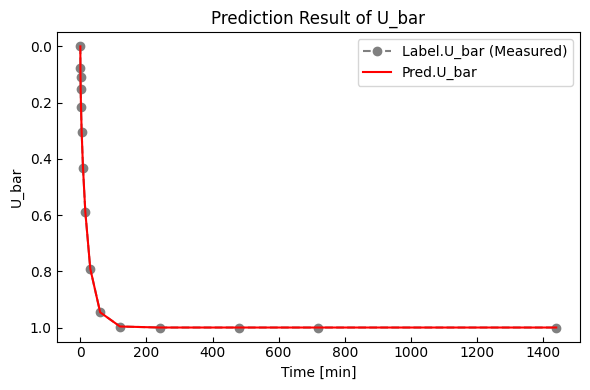

    Time [min]  Label.U_bar  Pred.U_bar
0         0.00   2.0262e-05 -3.6716e-05
1         0.25   7.6297e-02  7.6330e-02
2         0.50   1.0790e-01  1.0787e-01
3         1.00   1.5259e-01  1.5261e-01
4         2.00   2.1580e-01  2.1583e-01
5         4.00   3.0519e-01  3.0513e-01
6         8.00   4.3154e-01  4.3155e-01
7        15.00   5.8786e-01  5.8785e-01
8        30.00   7.9065e-01  7.9066e-01
9        60.00   9.4593e-01  9.4598e-01
10      120.00   9.9639e-01  9.9631e-01
11      240.00   9.9998e-01  9.9999e-01
12      480.00   1.0000e+00  1.0000e+00
13      720.00   1.0000e+00  9.9999e-01
14     1440.00   1.0000e+00  9.9999e-01

[Current Stage(L-BFGS)]: CT-1
□ L_data (after L-BFGS): 1.3731098e-09
□ True.c_v = 1.8288E-02 cm²/min (0.018288), 3.0480E-04 cm²/sec (0.000305)
□ Pred.c_v = 2.5596E-02 cm²/min (0.025596), 4.2661E-04 cm²/sec (0.000427)
□ c_v(Relative Error) = 39.963%


In [ ]:
### Cell-08 // PINN training(AL-BFGS) and result visualization
# L-BFGS: Re-compile with the same model (keeping L_data)
model.compile("L-BFGS",
              loss=["MSE", "MSE", "MSE"],
              external_trainable_variables=[c_v])
model.train()

# Result Visualization (L-BFGS)
t_tensor = tf.convert_to_tensor(t_exp, dtype=tf.float32)
U_pred = compute_U_bar_PINN(model, t_tensor, H).numpy()

plt.figure(figsize=(6, 4))
plt.plot(t_exp, U_exp, "o--", color="gray", label="Label.U_bar (Measured)")
plt.plot(t_exp, U_pred, "r-", label="Pred.U_bar")
plt.xlabel("Time [min]")
plt.ylabel("U_bar")
plt.title("Prediction Result of U_bar")
plt.legend()
plt.grid(False)
plt.tick_params(direction="in")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Store comparison in a DataFrame
df_compare = pd.DataFrame({
  "Time [min]": t_exp.flatten(),
  "Label.U_bar": U_exp.flatten(),
  "Pred.U_bar": U_pred.flatten()})

pd.set_option("display.precision", 4)
pd.set_option("display.max_rows", None)

print(df_compare)

# L_data error after L-BFGS training
print()
print(f"[Current Stage(L-BFGS)]: {current_stage}")
loss_lbfgs = custom_data_loss(model, t_exp, U_exp, H).numpy()
print(f"□ L_data (L-BFGS): {loss_lbfgs:.4E} ({loss_lbfgs:.6f})")
c_v_val = c_v.numpy()
print(f"□ True.c_v = {c_vi.numpy()*60:.4E} cm²/min ({c_vi.numpy()*60:.6f}), {c_vi.numpy():.4E} cm²/sec ({c_vi.numpy():.6f})")
print(f"□ Pred.c_v = {c_v.numpy():.4E} cm²/min ({c_v.numpy():.6f}), {c_v.numpy()/60:.4E} cm²/sec ({c_v.numpy()/60:.6f})")
print(f"□ c_v(Relative Error) = {((c_v.numpy()/60 - c_vi.numpy()) / c_vi.numpy())*100:.3f}%")

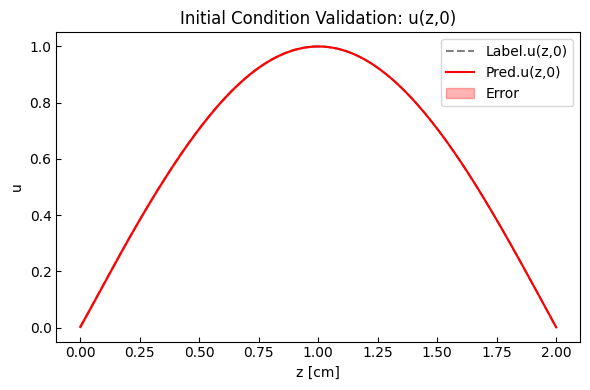

△ MSE Loss at u(z,0): 1.0479E-07 (0.000000)



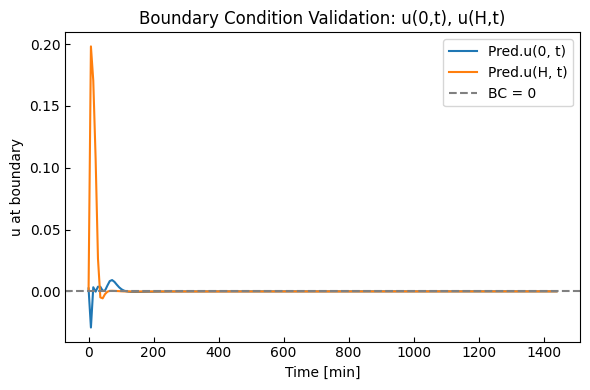

△ MSE Loss at z=0 (u(0,t)): 5.9023E-06 (0.000006)
△ MSE Loss at z=H (u(H,t)): 4.0297E-04 (0.000403)



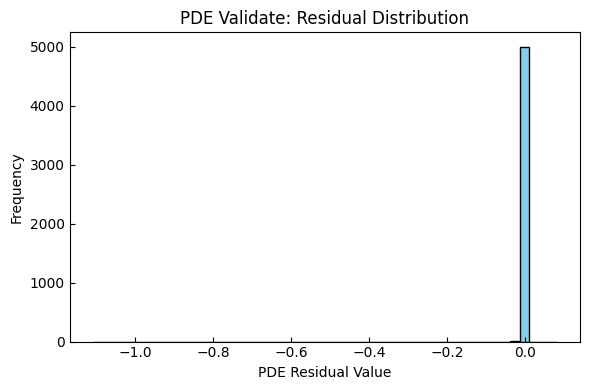

△ PDE Residual Average : -1.5724E-04 (-0.000157)
△ PDE Residual St.deviation: 1.5744E-02 (0.015744)



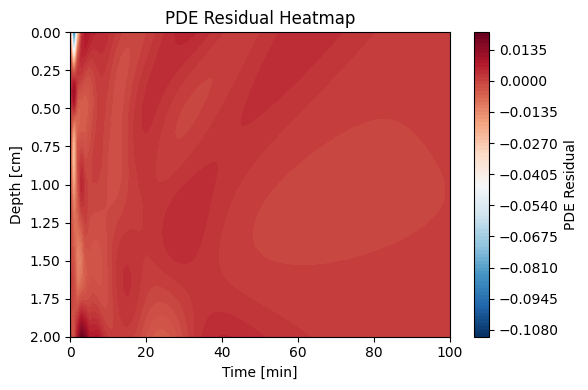

△ PDE Residual Heatmap



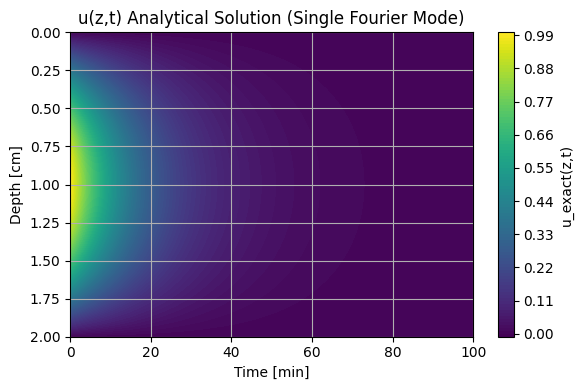

△ Analytical Solution (n=1 mode)



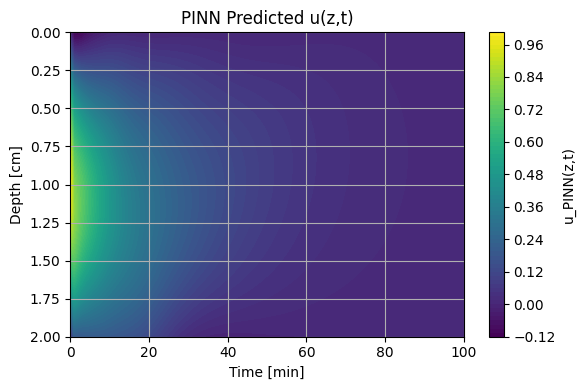

△ Pinn Predicted u(z,t)



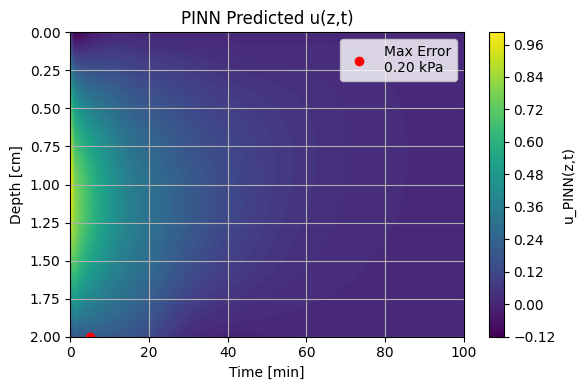

△ Max Error : z = 2.00 cm, t = 5.05 min, Error = 1.9911E-01 (0.1991) kPa
□ PINN - Analtiycal Soultion Error : 2.2138E-03 (0.002214)


In [ ]:
### Loss Visualization
# □ Initial Condition, u(z,0) Loss
# Grid
z_vals = np.linspace(0, H, 200).reshape(-1, 1)
t_zero = np.zeros_like(z_vals)
ZT = np.hstack([z_vals, t_zero])
u_pred = model.predict(ZT).flatten()
u_true = u_0 * np.sin(np.pi * z_vals.flatten() / H)
u_error = u_pred - u_true

# IC Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(z_vals, u_true, color="gray", label='Label.u(z,0)', linestyle='--')
plt.plot(z_vals, u_pred, color="red", label='Pred.u(z,0)')
plt.fill_between(z_vals.flatten(), u_true, u_pred, color='red', alpha=0.3, label='Error')
plt.xlabel("z [cm]")
plt.ylabel("u")
plt.title("Initial Condition Validation: u(z,0)")
plt.legend()
plt.grid(False)
plt.tick_params(direction="in")
plt.tight_layout()
plt.show()

# MSE Loss Calculation
mse_loss = np.mean((u_pred - u_true) ** 2)
print(f"△ MSE Loss at u(z,0): {mse_loss:.4E} ({mse_loss:.6f})")
print()

# □ Boundary Condition
t_vals = np.linspace(0, 1440.0, 200).reshape(-1, 1)
z0 = np.zeros_like(t_vals)
zH = np.ones_like(t_vals) * H
ZT_0 = np.hstack([z0, t_vals])
ZT_H = np.hstack([zH, t_vals])
u_pred_0 = model.predict(ZT_0).flatten()
u_pred_H = model.predict(ZT_H).flatten()

# BC Visualization
plt.figure(figsize=(6, 4))
plt.plot(t_vals, u_pred_0, label='Pred.u(0, t)')
plt.plot(t_vals, u_pred_H, label='Pred.u(H, t)')
plt.axhline(0.0, color='gray', linestyle='--', label='BC = 0')
plt.xlabel("Time [min]")
plt.ylabel("u at boundary")
plt.title("Boundary Condition Validation: u(0,t), u(H,t)")
plt.legend()
plt.grid(False)
plt.tick_params(direction="in")
plt.tight_layout()
plt.show()
u_true_bc = np.zeros_like(t_vals).flatten()

# MSE Loss Calculation
mse_bc_0 = np.mean((u_pred_0 - u_true_bc) ** 2)
mse_bc_H = np.mean((u_pred_H - u_true_bc) ** 2)
print(f"△ MSE Loss at z=0 (u(0,t)): {mse_bc_0:.4E} ({mse_bc_0:.6f})")
print(f"△ MSE Loss at z=H (u(H,t)): {mse_bc_H:.4E} ({mse_bc_H:.6f})")
print()

# □ PDE Loss
# Grid
num_samples = 5000
z_sample = np.random.uniform(0, H, size=(num_samples, 1))
t_sample = np.random.uniform(0, 1440.0, size=(num_samples, 1))
XT_sample = np.hstack([z_sample, t_sample])
XT_tensor = tf.convert_to_tensor(XT_sample, dtype=tf.float32)

# u(z, t) Prediction
with tf.GradientTape(persistent=True) as tape2:
    tape2.watch(XT_tensor)
    with tf.GradientTape() as tape1:
        tape1.watch(XT_tensor)
        u = model.net(XT_tensor)
    du = tape1.gradient(u, XT_tensor)
    du_t = du[:, 1:2]                  # time derivation
    du_z = du[:, 0:1]                  # second spatial derivative
du_zz = tape2.gradient(du_z, XT_tensor)[:, 0:1]

residual = du_t - c_v * du_zz

# PDE Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.hist(residual.numpy().flatten(), bins=50, color='skyblue', edgecolor='black')
plt.xlabel("PDE Residual Value")
plt.ylabel("Frequency")
plt.title("PDE Validate: Residual Distribution")
plt.tick_params(direction="in")
plt.tight_layout()
plt.show()

print(f"△ PDE Residual Average : {np.mean(residual.numpy()):.4E} ({np.mean(residual.numpy()):.6f})")
print(f"△ PDE Residual St.deviation: {np.std(residual.numpy()):.4E} ({np.std(residual.numpy()):.6f})")
print()

# □ PDE Residual Visualization
# Grid
z_vals = np.linspace(0, H, 100)
t_vals = np.linspace(0, 100, 100)                      # ◀ Graph Time Range def:(0, 1440, 100)
Z, T = np.meshgrid(z_vals, t_vals)
ZT = np.hstack([Z.flatten()[:, None], T.flatten()[:, None]])
ZT_tensor = tf.convert_to_tensor(ZT, dtype=tf.float32)

# Model Prediction and Gradient Computation
with tf.GradientTape(persistent=True) as tape2:
    tape2.watch(ZT_tensor)
    with tf.GradientTape() as tape1:
        tape1.watch(ZT_tensor)
        u = model.net(ZT_tensor)
    du = tape1.gradient(u, ZT_tensor)
    du_t = du[:, 1:2]
    du_z = du[:, 0:1]
du_zz = tape2.gradient(du_z, ZT_tensor)[:, 0:1]

residual = du_t - c_v * du_zz
res_grid = residual.numpy().reshape(100, 100)

# Visualization
plt.figure(figsize=(6, 4))
plt.contourf(T, Z, res_grid, levels=100, cmap="RdBu_r")
plt.colorbar(label="PDE Residual")
plt.xlabel("Time [min]")
plt.ylabel("Depth [cm]")
plt.title("PDE Residual Heatmap")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
print("△ PDE Residual Heatmap")
print()

# □ PDE Heatmap (Analytical Solution)
# Analytical Solution (n=1 mode)
def exact_solution(x):
    z = x[:, 0:1]
    t = x[:, 1:2]
    return u_0 * tf.sin(np.pi * z / H) * tf.exp(-c_v * (np.pi / H)**2 * t)

# PINN Prediction
u_pred = model.predict(ZT).reshape(100, 100)

# Analytical Solution Calculation
ZT_tensor = tf.convert_to_tensor(ZT, dtype=tf.float32)
u_exact = exact_solution(ZT_tensor).numpy().reshape(100, 100)

# Analytical Solution Heatmap
plt.figure(figsize=(6, 4))
plt.contourf(T, Z, u_exact, levels=100, cmap="viridis")
plt.colorbar(label="u_exact(z,t)")
plt.xlabel("Time [min]")
plt.ylabel("Depth [cm]")
plt.title("u(z,t) Analytical Solution (Single Fourier Mode)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()
print("△ Analytical Solution (n=1 mode)")
print()

# □ PINN Heatmap
plt.figure(figsize=(6, 4))
cp = plt.contourf(T, Z, u_pred, levels=100, cmap="viridis")
plt.colorbar(cp, label="u_PINN(z,t)")
plt.xlabel("Time [min]")
plt.ylabel("Depth [cm]")
plt.title("PINN Predicted u(z,t)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()
print("△ Pinn Predicted u(z,t)")
print()

# Find Maximum Error Point
error_grid = np.abs(u_pred - u_exact)
max_error_idx = np.unravel_index(np.argmax(error_grid), error_grid.shape)
max_z_idx, max_t_idx = max_error_idx
max_z = Z[max_z_idx, max_t_idx]
max_t = T[max_z_idx, max_t_idx]
max_error_val = error_grid[max_z_idx, max_t_idx]

# □ PINN Heatmap + Maximum Error Point
plt.figure(figsize=(6, 4))
cp = plt.contourf(T, Z, u_pred, levels=100, cmap="viridis")
plt.plot([max_t], [max_z], 'ro', label=f'Max Error\n{max_error_val:.2f} kPa')
plt.colorbar(cp, label="u_PINN(z,t)")
plt.xlabel("Time [min]")
plt.ylabel("Depth [cm]")
plt.title("PINN Predicted u(z,t)")
plt.legend()
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

# PINN and Analytical Solution Heatmap MSE Calculation
mse_loss = np.mean((u_pred - u_exact) ** 2)
print(f"△ Max Error : z = {max_z:.2f} cm, t = {max_t:.2f} min, Error = {max_error_val:.4E} ({max_error_val:.4f}) kPa")
print(f"□ PINN - Analtiycal Soultion Error : {mse_loss:.4E} ({mse_loss:.6f})")

In [ ]:
# End of the Code